<H2>Create face:label dictionary</H2>
    
The aim of this notebook is to create a set of labelled data to train our ML model (most likely convNet)

In [2]:
import os
import cv2
import spacy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [3]:
def convert_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
nlp = spacy.load('en')
caption_file = '../data/raw/labeledCaptions.mat'
labels = loadmat(caption_file)
all_captions = labels['captions']
haarCascade = '../opencv-3.3.1/data/haarcascades/haarcascade_frontalface_alt.xml'
faceDetector = cv2.CascadeClassifier(haarCascade)

Firstly, we need to get rid of the photographers' names from our captions

In [5]:
def names_from_captions(details):
    cleaned_details = []
    for i in range(np.shape(details)[1]):
        cleaned_details.append(str(details[:,i].tolist()).split('dtype')[0][:-30])
    #Create dictionary with img-name:face-name format
    cleaned_captions={}
    for i in range(np.shape(cleaned_details)[0]):
        cap = str(cleaned_details[i])
        doc = nlp(str(cap))
        people = []
        dates=[]
        for ent in doc.ents:
            if ent.label_=='PERSON' and len(ent.text) > 2:
                name = ent.text
                if name[0]=="'" or name[0]=="\"":
                    name=name[1:]
                if name[-1]=="'" or name[-1]=="\"":
                    name=name[-1]
                if not name.startswith("array") and len(name)>2:
                    people.append(name)
        cap2 = str(details[:,i])
        img_name = cap2.split('.jpg')[0].split('array([\'20')[1]
        if img_name[:2]=='03'and img_name[3:5] in ['01','02','03']:
            cleaned_captions[str(img_name)] = np.unique(people)
    return cleaned_captions

In [6]:
img_dict = names_from_captions(all_captions)

In [7]:
print(img_dict)

{'03/01/19/img_592': array(['Actor', 'Downey', 'Robert Downey'],
      dtype='<U13'), '03/01/21/img_192': array(['Bush', 'John Snow', 'Kevin Lamarque', "Paul O'Neill", 'Snow'],
      dtype='<U14'), '03/03/07/img_1119': array(['Latifah'],
      dtype='<U7'), '03/03/04/img_1024': array(['Henri Proglio', 'Proglio'],
      dtype='<U13'), '03/02/24/img_635': array(['AP Pho', 'Gerhard Schroeder', 'Jacques Chirac'],
      dtype='<U17'), '03/02/18/img_467': array(['Gephardt', 'Richard Gephardt'],
      dtype='<U16'), '03/03/06/img_177': array(['Bush', 'George W'],
      dtype='<U8'), '03/03/17/img_1137': array(['> Ann Roth', 'Meryl Streep'],
      dtype='<U12'), '03/02/03/img_309': array(['Imad Khadduri', 'Khadduri', 'Pho'],
      dtype='<U13'), '03/03/04/img_493': array(['Peter Gabriel'],
      dtype='<U13'), '03/01/18/img_324': array([], dtype=float64), '03/01/23/img_441': array(['Igor Ivanov', 'Ivanov'],
      dtype='<U11'), '03/01/19/img_962': array(['Chavez', 'Hugo Chavez'],
      dtype='

In [8]:
def face_positions(cleaned_captions):
    correctly_detected_clean = {}
    correct_positions_clean = {}
    for key, value in cleaned_captions.items():
        people = value
        img_path = "../data/raw/%s.jpg"%key[3:]
        img = cv2.imread(img_path)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceDetector.detectMultiScale(img_grey, 1.3, 5)
        posns=[]
        for x,y,w,h in faces:
            posns.append([x,y,w,h])
            #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        ground_truth_names =  [name for name in value if str(" ") in name] 
        if len(ground_truth_names)==len(faces):
            correctly_detected_clean[key] = value
            correct_positions_clean[key] = posns
    return correct_positions_clean

In [10]:
posn_dict = face_positions(img_dict)

In [11]:
names = img_dict['03/03/02/img_428']
posns = posn_dict['03/03/02/img_428']
img = cv2.imread('../data/raw/03/02/img_428.jpg')
print(names)
print(posns)

['Daldry' 'Julianne Moore' 'Stephen Daldry']
[[119, 115, 125, 125], [20, 38, 144, 144]]


In [1]:
def face_match_name(img_path, plot=False):
    names = img_dict[img_path]
    posns = posn_dict[img_path]
    faces = []
    
    for i in range(len(posns)):
        x,y,w,h = posns[i][0],posns[i][1],posns[i][2],posns[i][3]
        img = cv2.imread('../data/raw/%s.jpg'%img_path[3:])
        face_extract = img[y:y+h, x:x+h]
        fig, axes = plt.subplots(1, len(posns), sharey=True)
        #print(names[i])
        faces.append(face_extract)
        if plot:            
            #print("Names: %s"%names)
            #print("Face locations: ",posns)
            
            if len(posns)>1:
                axes[i].imshow(convert_to_rgb(face_extract))
            else:
                axes.imshow(convert_to_rgb(face_extract))
    return names, faces
names1, faces1 = face_match_name('03/03/02/img_428', plot=True)
print(names1)

NameError: name 'img_dict' is not defined

['Brooks' 'Vince Brooks']


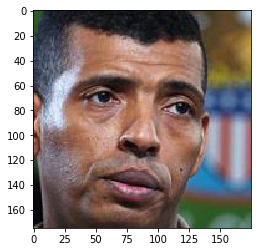

In [24]:
names2, faces2 = face_match_name('03/03/31/img_1082', plot=True)
print(names2)

['> Regan Upshaw']


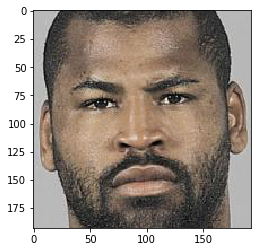

In [25]:
names3, faces3 = face_match_name('03/01/23/img_725', plot=True)
print(names3)

Now we have a way to extract faces and labels from an image, we want to store the face examples for each name. In many cases there will be more than one image per name.

In [26]:
correct_extracts = {}
for key, value in img_dict.items():
    try:
        names, faces = face_match_name(key)
    except:
        continue
    for i in range(len(faces)):
        if not names[i] in correct_extracts:
            correct_extracts[names[i]]= [faces[i]]
        else:
            
            correct_extracts[names[i]].append(faces[i])
            #print("%s has more than one entry. New shape of this entry:"%(names[i], \
            #                                                              np.shape(correct_extracts[names[i]])))

In [27]:
len(correct_extracts['Norah Jones'])

10

In [28]:
with open('../data/processed/labelled_faces.txt', 'wb') as f:
    np.save(f, correct_extracts)